# Walkability analysis notebook

This notebook takes the data objects saved in `data/prepared/` and produced by `data_ingestion.ipynb`, and operates on them to create measures of walkability by geography.

This is achieved by computing the shortest walking distance to different categories of place, and averaging it across each geography.

This requires trips to be generated and analysed:

1. Constructing the starting points. We distribute starting points along the network nodes with a density proportional to the local population (at SA1 granularity)
2. Finding the end points. From each starting point, we want to obtain a sample of end points from point-of-interest data that is within some walking distance (e.g. 5km)
3. Constructing the trips. Each trip is a pair of a start point and the local end points, which are mapped to the geographically closest network node.
4. Compute the distance of all trips on the graph, using the edge weights, and take the minimum per category of destination, and the number within the search radius. Network libraries perform this efficiently.
5. This minimum distance and count per category are properties of the starting location. Statistics per geographic area can be computed by averaging them across the starting locations in the geography.
6. The walkability measures can be used in combination with other census data to investigate causal factors and correlates of walkability



In [1]:
# imports, with everything converted to meters for distances

# libraries

import pandas as pd
import geopandas as gpd
import numpy as np
import pandana as pdna
import itertools
from shapely.geometry import Point
from functools import reduce


# point of interest geodataframes

coffee_gdf = gpd.read_feather('data/prepared/coffee.feather').to_crs("EPSG:7855") # everywhere you can get a coffee in Melbourne
places_gdf = gpd.read_feather('data/prepared/places.feather').to_crs("EPSG:7855") # general places of interest

# geography geodataframes

lga_gdf = gpd.read_feather('data/prepared/lga.feather').to_crs("EPSG:7855") # local gov areas
poa_gdf = gpd.read_feather('data/prepared/poa.feather').to_crs("EPSG:7855") # postcodes
sal_gdf = gpd.read_feather('data/prepared/sal.feather').to_crs("EPSG:7855") # suburbs
sa1_gdf = gpd.read_feather('data/prepared/sa1.feather').to_crs("EPSG:7855") # SA1 statistical areas

# road network data

edges = pd.read_feather('data/prepared/graph_edges.feather')
nodes = pd.read_feather('data/prepared/graph_nodes.feather')

# construct pandana network object

network_definition = {
    'node_x': nodes['x'],
    'node_y': nodes['y'],
    'edge_from': edges['u'],
    'edge_to': edges['v'],
    'edge_weights': edges[['w']], # length in metres
    'twoway': True
}

graph = pdna.Network(**network_definition)


Generating contraction hierarchies with 12 threads.
Setting CH node vector of size 1689061
Setting CH edge vector of size 3885064
Range graph removed 3885342 edges of 7770128
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


## Construction of starting points

In [2]:
print(f'{sa1_gdf.population.sum():,} people live in the SA1s of interest, which will be distributed across {len(nodes):,} nodes ({sa1_gdf.population.sum()/len(nodes):,.2} persons per node)')

3,921,481 people live in the SA1s of interest, which will be distributed across 1,689,061 nodes (2.3 persons per node)


In [3]:
nodes_df = graph.nodes_df

nodes_df['geometry'] = nodes_df.apply(lambda row: Point(row['x'],row['y']), axis=1)
nodes_gdf = gpd.GeoDataFrame(nodes_df,geometry='geometry', crs="EPSG:7855").reset_index()

# attach population numbers
nodes_gdf = gpd.sjoin(nodes_gdf,sa1_gdf[['population','geometry','geography_name']], how='left')

# compute weights per node (how many people each node represents)
node_counts_per_sl1 = nodes_gdf.groupby('geography_name').size().reset_index(name='node_count')
nodes_gdf = nodes_gdf.merge(node_counts_per_sl1, on='geography_name', how='left')
nodes_gdf['node_weight'] = nodes_gdf['population'] / nodes_gdf['node_count'].replace(0, 1)

## Construction of destination points

In [4]:

# returns the same gdf with the closest node ids in a column (if there's one close enough)
def find_nearest_nodes(poi_gdf, graph, max_dist_m=30):
    # Create a copy of the poi_gdf to avoid modifying the original dataframe
    poi_gdf = poi_gdf.copy()

    # Extract x and y coordinates
    xs = poi_gdf.geometry.x.values
    ys = poi_gdf.geometry.y.values

    # Find the nearest nodes
    nearest_nodes = graph.get_node_ids(xs, ys, mapping_distance=max_dist_m)
    poi_gdf['nearest_node'] = nearest_nodes

    # Calculate unmatched locations
    unmatched = poi_gdf['nearest_node'].isna().sum()
    print(f'{unmatched} locations were not able to be matched within {max_dist_m}m')

    # Filter out unmatched locations
    matched_nodes = poi_gdf.dropna(subset=['nearest_node']).copy()

    for node_id in matched_nodes['nearest_node'].unique():
        matched_nodes.loc[matched_nodes['nearest_node'] == node_id, 'node_x'] = graph.nodes_df.loc[node_id].x
        matched_nodes.loc[matched_nodes['nearest_node'] == node_id, 'node_y'] = graph.nodes_df.loc[node_id].y

    return matched_nodes

# Apply the function to the GeoDataFrames
place_nodes_gdf = find_nearest_nodes(places_gdf, graph)
coffee_nodes_gdf = find_nearest_nodes(coffee_gdf, graph)


coffee_nodes_gdf


7580 locations were not able to be matched within 30m
374 locations were not able to be matched within 30m


,name,category,source,geometry,nearest_node,node_x,node_y
0,North Point Cafe,coffee_available,here_api,POINT (323029.685 5803637.676),5.713212e+08,323045.021224,5.803636e+06
1,Ladygreen,coffee_available,here_api,POINT (323691.895 5803852.887),7.403699e+08,323694.027992,5.803872e+06
2,Superrandom,coffee_available,here_api,POINT (323688.855 5803830.618),1.110030e+10,323688.246534,5.803827e+06
3,The Little Ox,coffee_available,here_api,POINT (323715.194 5804037.679),9.976415e+09,323713.761008,5.804029e+06
4,Saint Martins Cafe,coffee_available,here_api,POINT (324355.613 5803711.709),1.109813e+10,324365.498083,5.803710e+06
...,...,...,...,...,...,...,...
4828,Crafty Cafe,coffee_available,here_api,POINT (315917.835 5837023.927),3.218886e+09,315911.566771,5.837027e+06
4829,Max Brenner,coffee_available,here_api,POINT (315767.171 5837046.113),1.028948e+10,315779.341584,5.837032e+06
4830,THE COFFEE CLUB,coffee_available,here_api,POINT (315854.779 5837237.901),5.936035e+09,315849.322112,5.837258e+06
4831,Donut King,coffee_available,here_api,POINT (315704.033 5837104.659),1.028948e+10,315701.919566,5.837109e+06


## Calculating distances on the graph

In [57]:
max_distance = 5000
max_items = 1000

destination_nodes_gdf = pd.concat([
    place_nodes_gdf[['name','category','node_x','node_y','nearest_node']],
    coffee_nodes_gdf[['name','category','node_x','node_y','nearest_node']]
])

categories = destination_nodes_gdf['category'].unique()

for category in categories:
    filtered_destinations = destination_nodes_gdf[destination_nodes_gdf['category']==category]
    graph.set_pois(category,max_distance,max_items,filtered_destinations['node_x'],filtered_destinations['node_y'])

graph.poi_category_names


['restaurant',
 'grocery or supermarket',
 'cafe',
 'bar or pub',
 'place of worship',
 'tourist attraction',
 'community area',
 'aged care',
 'park area',
 'school',
 'child care',
 'library',
 'emergency services',
 'medical facility',
 'entertainment centre',
 'swimming pool',
 'tertiary institution',
 'art gallery',
 'museum',
 'coffee_available']

In [58]:

# interested in returning, per category, how close is the closest, and how many are within 500m, 1km, 2km etc (up to a max of 100)
# This is a very heavy query, depending on the search horizon


def summarise_distances_per_node(category):
    df = graph.nearest_pois(distance=max_distance, category=category, num_pois=max_items)
    df_out = df.copy()[[1]]
    df_out[category + ' - within 2km'] = (df < 2000).sum(axis=1)
    df_out[category + ' - within 1km'] = (df < 1000).sum(axis=1)
    df_out[category + ' - within 500m'] = (df < 500).sum(axis=1)
    df_out[category + ' - within 200m'] = (df < 200).sum(axis=1)
    df_out[category + ' - closest'] = df.min(axis=1).replace(max_distance, np.nan)
    return df_out.drop(columns=[1])


summaries = []

for category in categories:
    summaries.append(summarise_distances_per_node(category))
    print(f'{len(summaries)} of {len(categories)} done')

distances_df = reduce(lambda left, right: pd.merge(left, right, on='osmid'), summaries)

final_nodes_gdf = nodes_gdf.merge(distances_df.reset_index(),how='left',on=['osmid']).drop(columns = ['index_right', 'geography_name','population','node_count'])

final_nodes_gdf.to_feather('data/final/final_nodes.feather')


1 of 20 done
2 of 20 done
3 of 20 done
4 of 20 done
5 of 20 done
6 of 20 done
7 of 20 done
8 of 20 done
9 of 20 done
10 of 20 done
11 of 20 done
12 of 20 done
13 of 20 done
14 of 20 done
15 of 20 done
16 of 20 done
17 of 20 done
18 of 20 done
19 of 20 done
20 of 20 done


## Aggregate across different geographies

In [68]:
final_nodes_gdf

,osmid,x,y,geometry,node_weight,restaurant - within 2km,restaurant - within 1km,restaurant - within 500m,restaurant - within 200m,restaurant - closest,...,museum - within 2km,museum - within 1km,museum - within 500m,museum - within 200m,museum - closest,coffee_available - within 2km,coffee_available - within 1km,coffee_available - within 500m,coffee_available - within 200m,coffee_available - closest
0,579259,335501.287752,5.800198e+06,POINT (335501.288 5800197.764),6.746032,77,18,3,0,345.002014,...,0,0,0,0,NaN,23,9,3,0,345.002014
1,579260,335384.338411,5.799317e+06,POINT (335384.338 5799316.967),1.898462,43,1,0,0,759.739990,...,0,0,0,0,NaN,16,1,0,0,759.739990
2,579261,336519.448334,5.799162e+06,POINT (336519.448 5799161.688),5.699507,48,6,4,4,0.000000,...,0,0,0,0,NaN,17,3,2,2,0.000000
3,579265,336613.589061,5.799543e+06,POINT (336613.589 5799542.632),0.000000,32,6,0,0,583.995972,...,0,0,0,0,NaN,13,3,0,0,583.995972
4,579267,336507.598142,5.801855e+06,POINT (336507.598 5801855.350),0.392593,54,22,1,1,68.067001,...,0,0,0,0,NaN,17,4,0,0,797.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689056,11276470586,314088.029452,5.823816e+06,POINT (314088.029 5823816.206),0.004011,39,22,20,0,220.656998,...,0,0,0,0,NaN,19,12,9,0,255.046997
1689057,11276470587,314089.840541,5.823811e+06,POINT (314089.841 5823811.373),0.004011,39,22,20,0,215.488998,...,0,0,0,0,NaN,19,12,9,0,249.878998
1689058,11276470588,314093.420333,5.823803e+06,POINT (314093.420 5823802.805),0.004011,39,22,20,0,206.177002,...,0,0,0,0,NaN,19,12,9,0,240.567001
1689059,11276470589,314096.489426,5.823798e+06,POINT (314096.489 5823797.723),0.004011,39,22,20,0,200.235001,...,0,0,0,0,NaN,19,12,9,0,234.625000


In [112]:
# we define a function to join any geography onto the nodes, using the node weights

def get_geography_summary_table(geography_gdf):

    def weighted_mean(group, value_columns, weight_column):
        weighted_sum = group[value_columns].multiply(group[weight_column], axis="index").sum()
        total_weight = group[weight_column].sum()
        # Handle the case where the total weight is zero to avoid division by zero.
        return weighted_sum / total_weight if total_weight != 0 else None

    left_nodes = final_nodes_gdf.drop(columns=['osmid','x','y'])
    right_geography = geography_gdf.drop(columns=['link_key','geography'])

    joined_gdf = gpd.sjoin(left_nodes,right_geography,how='right').fillna(max_distance)

    cleaned_gdf = joined_gdf.drop(columns=['index_left'])

    value_cols = cleaned_gdf.columns.difference(['geography_name','node_weight','geometry'])

    result = joined_gdf.groupby(['geography_name']).apply(
        weighted_mean,
        value_columns=value_cols,
        weight_column='node_weight'
    )

    result['population_density'] = result['population']/result['area_sqkm']
    result['dwelling_density'] = result['private_dwellings']/result['area_sqkm']

    return geography_gdf[['geography_name','geometry']].merge(result.reset_index(),on=['geography_name'])


complete_sa1_gdf = get_geography_summary_table(sa1_gdf)
complete_sal_gdf = get_geography_summary_table(sal_gdf)
complete_poa_gdf = get_geography_summary_table(poa_gdf)
complete_lga_gdf = get_geography_summary_table(lga_gdf)

complete_sa1_gdf.to_feather('data/final/final_sa1.feather')
complete_sal_gdf.to_feather('data/final/final_sal.feather')
complete_poa_gdf.to_feather('data/final/final_poa.feather')
complete_lga_gdf.to_feather('data/final/final_lga.feather')


## Graphs

In [117]:
final_nodes_gdf

,osmid,x,y,geometry,node_weight,restaurant - within 2km,restaurant - within 1km,restaurant - within 500m,restaurant - within 200m,restaurant - closest,...,museum - within 2km,museum - within 1km,museum - within 500m,museum - within 200m,museum - closest,coffee_available - within 2km,coffee_available - within 1km,coffee_available - within 500m,coffee_available - within 200m,coffee_available - closest
0,579259,335501.287752,5.800198e+06,POINT (335501.288 5800197.764),6.746032,77,18,3,0,345.002014,...,0,0,0,0,NaN,23,9,3,0,345.002014
1,579260,335384.338411,5.799317e+06,POINT (335384.338 5799316.967),1.898462,43,1,0,0,759.739990,...,0,0,0,0,NaN,16,1,0,0,759.739990
2,579261,336519.448334,5.799162e+06,POINT (336519.448 5799161.688),5.699507,48,6,4,4,0.000000,...,0,0,0,0,NaN,17,3,2,2,0.000000
3,579265,336613.589061,5.799543e+06,POINT (336613.589 5799542.632),0.000000,32,6,0,0,583.995972,...,0,0,0,0,NaN,13,3,0,0,583.995972
4,579267,336507.598142,5.801855e+06,POINT (336507.598 5801855.350),0.392593,54,22,1,1,68.067001,...,0,0,0,0,NaN,17,4,0,0,797.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689056,11276470586,314088.029452,5.823816e+06,POINT (314088.029 5823816.206),0.004011,39,22,20,0,220.656998,...,0,0,0,0,NaN,19,12,9,0,255.046997
1689057,11276470587,314089.840541,5.823811e+06,POINT (314089.841 5823811.373),0.004011,39,22,20,0,215.488998,...,0,0,0,0,NaN,19,12,9,0,249.878998
1689058,11276470588,314093.420333,5.823803e+06,POINT (314093.420 5823802.805),0.004011,39,22,20,0,206.177002,...,0,0,0,0,NaN,19,12,9,0,240.567001
1689059,11276470589,314096.489426,5.823798e+06,POINT (314096.489 5823797.723),0.004011,39,22,20,0,200.235001,...,0,0,0,0,NaN,19,12,9,0,234.625000


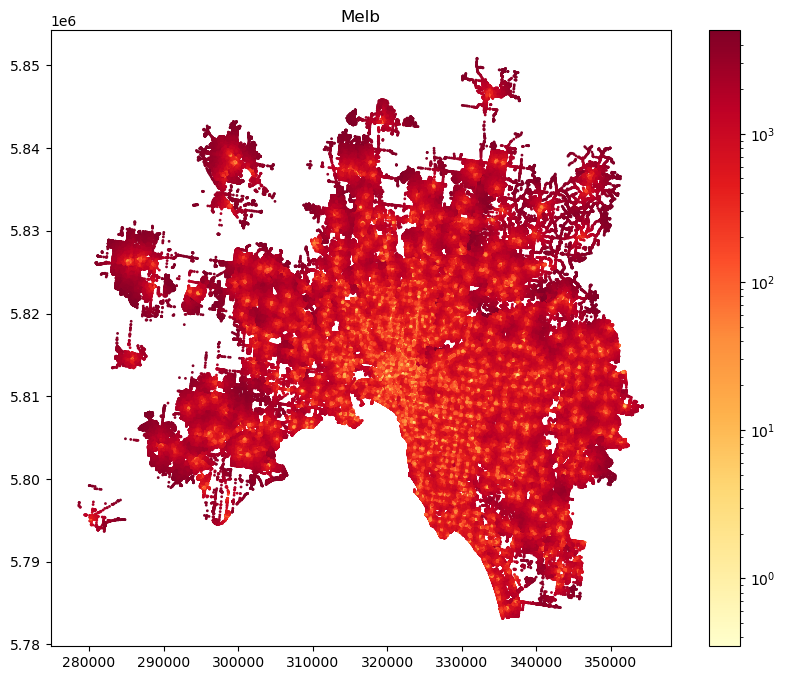

In [120]:
import matplotlib
from matplotlib import pyplot as plt


fig, ax = plt.subplots(figsize=(10,8))

plt.title('Melb')
plt.scatter(final_nodes_gdf.x, final_nodes_gdf.y, 
            c=final_nodes_gdf['coffee_available - closest'],
            s=1, cmap='YlOrRd',
            norm=matplotlib.colors.LogNorm())
cb = plt.colorbar()

plt.show()